# NUS Fintech ML Project 2 (NLP Sentiment Analysis)
This project aims to classify text data as either positive or negative sentiment, so as to act as a proxy to predict the potential price movement of the stock market. This project explores the use of NLP and specifically the BERT (Bidirectional Encoder Representations from Transformers) Transformer-based Deep Learning model.

### Model Decision:
The main 3 models considered were the LSTM, BERT deep learning models and VADER (Valence Aware Dictionary for Sentiment Reasoning). After research on the specific use case of sentiment analysis on text for stock data sentiment analysis, I felt that a pretrained roBERTa transformer model would be more well suited mainly due to the data set context. Since the dataset has shown to be financial social media posts, it is important the model seected is able to pick up the intricacies of such texts. Moreover, a BERT trained on financial data may be advantageous in this project.
* https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
* https://towardsdatascience.com/choosing-the-right-language-model-for-your-nlp-use-case-1288ef3c4929
* https://towardsdatascience.com/lstm-vs-bert-a-step-by-step-guide-for-tweet-sentiment-analysis-ced697948c47
* https://medium.com/prosus-ai-tech-blog/finbert-financial-sentiment-analysis-with-bert-b277a3607101
* https://towardsdatascience.com/can-we-beat-the-stock-market-using-twitter-ef8465fd12e2

### To summarise:
* The chosen model, roBERTa, is a variant of BERT developed by Soleimanian. This model, being a BERT architecture, excels in handling the complexity of language, making it well-suited for our financial sentiment analysis project. Moreover, this model was trained on financial data, which offers a strategic advantage. The unique characteristics of financial language and terminology can be better understood and interpreted by a model fine-tuned on similar content.

## 1 Data Exploration
* We will first explore the given dataset to get a preliminary view of the data we are working with.
1. Classification Distribution to check for class imbalance
2. Text length distribution as well as maximum sequence length

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("stock_data.csv")

In [2]:
data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [4]:
data.describe()

,Sentiment
count,5791.000000
mean,0.272664
std,0.962192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


* This shows that there are no missing data and the sentiment score is labeled 1 for positive and -1 for negative.
* We will now plot the distribution of sentiments to at least be aware of any overly excessive unevenness in the sentiments

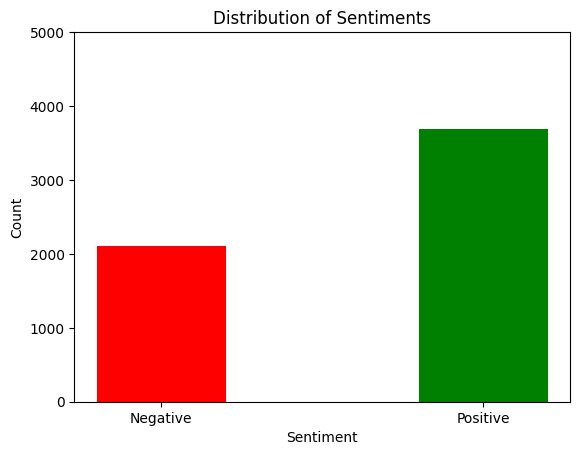

In [5]:
counts = data['Sentiment'].value_counts()

# Bar plot to see the distribution of +ve and -ve
plt.bar(counts.index, counts.values, color=['green', 'red'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.ylim(0, 5000)
plt.xticks(counts.index, ['Positive', 'Negative'])
plt.show()

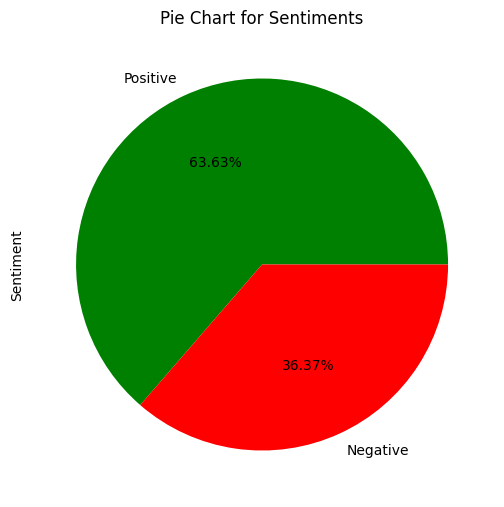

In [6]:
plt.figure(figsize=(6, 8))
data['Sentiment'].value_counts().plot.pie(autopct='%0.2f%%', labels=['Positive', 'Negative'], colors=['green', 'red'])
plt.title("Pie Chart for Sentiments")
plt.show()

* The number of positive sentiments is about double the negative sentiment. We will simply keep this in mind and there is no need to artificially rebalance the data
* https://stats.stackexchange.com/questions/59381/how-to-balance-classification/59382#59382
* https://stats.stackexchange.com/questions/227088/when-should-i-balance-classes-in-a-training-data-set
* https://datascience.stackexchange.com/questions/103667/how-can-i-balance-sentence-data-for-nlp-tasks

---



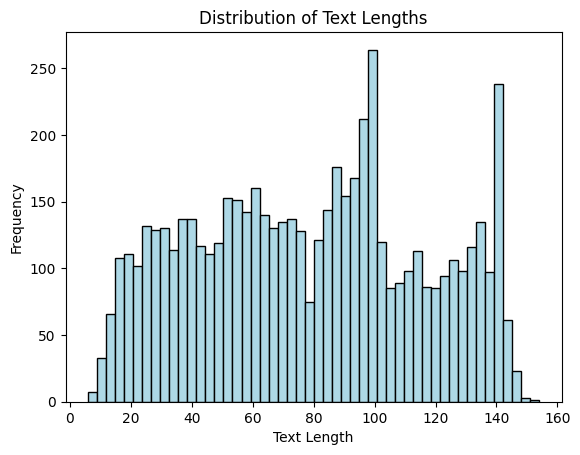

In [7]:
text_lengths = data['Text'].apply(len)

plt.hist(text_lengths, bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


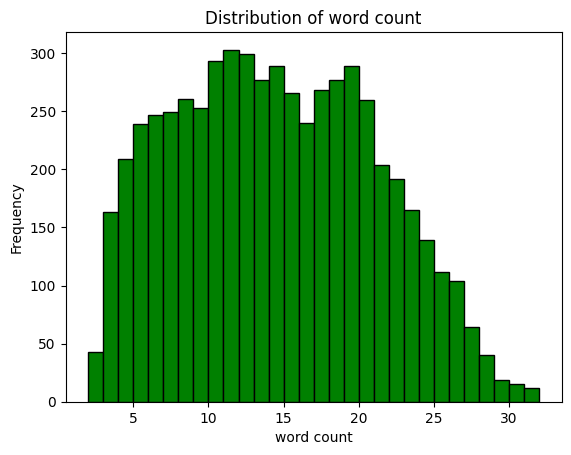

In [8]:
data['word count'] = data['Text'].apply(lambda x: len(x.split()))

# Plotting the histogram
plt.hist(data['word count'], bins=30, color='green', edgecolor='black')
plt.title('Distribution of word count')
plt.xlabel('word count')
plt.ylabel('Frequency')
plt.show()

* Based on the word count, the text data can be seen to be quite short.
* Based on the eye text, the text data is quite likely social media posts, VADER is specifically designed to handle such data.

## 3 roBERTa download and prediction
* We will download the pretrained roBERTa model and use it to directly predict the sentiment of each of our data.

In [9]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.nn.functional import softmax

# Load pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('soleimanian/financial-roberta-large-sentiment')
model = RobertaForSequenceClassification.from_pretrained('soleimanian/financial-roberta-large-sentiment')

In [10]:
model.config.id2label

{0: 'negative', 1: 'neutral', 2: 'positive'}

* We will utilise the roBERTa model to perform a prediction over all items in the dataset
* We can add a column "Predicted" as well as the probability for that sentiment and compare the results.
* Since roBERTa uses three labels, positive, neutral and negative, we will only take the positive and negative labels for this project.
* To handle the issue of 3 labels, we will take the higher probability of the predicted label. If the predicted label is neutral, we will decide between:
  * i.  taking the higher probability between the other two labels
  * ii. automatically taking positive, on the basis that all sentiments are positive until it shows a negative sentiment.

In [11]:
data["Sentiment"] = data["Sentiment"].map({1 : "positive", -1: "negative"})
data.head()

,Text,Sentiment,word count
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,positive,20
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,positive,16
2,user I'd be afraid to short AMZN - they are lo...,positive,18
3,MNTA Over 12.00,positive,3
4,OI Over 21.37,positive,3


In [12]:
X = data['Text']
y = data['Sentiment']

## Prediction 1: Taking positive if roBERTa model predicts neutral

In [13]:
import scipy
from tqdm import tqdm
import torch

preds = []
preds_proba = []

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

# Use tqdm to show a progress bar
for x in tqdm(X, desc="Processing texts"):
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),
                scipy.special.softmax(logits.numpy().squeeze()),
            )
        }

        # Choose the sentiment with the highest probability
        sentimentBERT = max(scores, key=scores.get)

        # always take positive
        # Check if the predicted sentiment is 'Neutral'
        if sentimentBERT == 'neutral':
            # if neutral ignore neutral and choose positive
            sentimentBERT = "positive"

        # Get the probability of the chosen sentiment
        probabilityBERT = scores[sentimentBERT]

        preds.append(sentimentBERT)
        preds_proba.append(probabilityBERT)

Processing texts: 100%|██████████| 5791/5791 [40:27<00:00,  2.39it/s]


## Prediction 2: Taking the higher probability if roBERTa predicts neutral

In [17]:
import scipy
from tqdm import tqdm
import torch

preds_take_next = []
preds_proba_take_next = []

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

# Use tqdm to show a progress bar
for x in tqdm(X, desc="Processing texts"):
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),
                scipy.special.softmax(logits.numpy().squeeze()),
            )
        }

        # Choose the sentiment with the highest probability
        sentimentBERT = max(scores, key=scores.get)

        if sentimentBERT == 'neutral':
            scores.pop('neutral')
            # Ignore neutral and choose the next highest probability
            sentimentBERT = max(scores, key=scores.get)

        # Get the probability of the chosen sentiment
        probabilityBERT = scores[sentimentBERT]

        preds_take_next.append(sentimentBERT)
        preds_proba_take_next.append(probabilityBERT)

Processing texts: 100%|██████████| 5791/5791 [38:48<00:00,  2.49it/s]


# 4 Evaluation
* we rely on the confusion matrix to evaluate our model as well as a classfication report to measure the accuracy of our model in classifying positive and negative texts.

In [14]:
#metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## Evaluation 1: Taking positive if roBERTa model predicts neutral

In [15]:
print(f'Accuracy-Score: {accuracy_score(y, preds)}')

Accuracy-Score: 0.7300984285960974


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y, preds, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    positive       0.68      0.48      0.57      2106
    negative       0.75      0.87      0.80      3685

    accuracy                           0.73      5791
   macro avg       0.71      0.68      0.69      5791
weighted avg       0.72      0.73      0.72      5791



## Evaluation 2: Taking the higher probability if roBERTa model predicts neutral

In [22]:
print(f'Accuracy-Score for take next: {accuracy_score(y, preds_take_next)}')

Accuracy-Score for take next: 0.7214643412191332


In [23]:
from sklearn.metrics import classification_report

# Assuming 'positive' is the positive class label and 'negative' is the negative class label
print(classification_report(y, preds_take_next, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.61      0.63      0.62      2106
    positive       0.79      0.77      0.78      3685

    accuracy                           0.72      5791
   macro avg       0.70      0.70      0.70      5791
weighted avg       0.72      0.72      0.72      5791



## Conclusion
* The difference between the handling of the 3 labels from the pre-trained roBERTa model is minute.
* Overall, the pre-trained finance based roBERTa model from soleimanian/financial-roberta-large-sentiment on this dataset has shown an accuracy of 72% - 73%
* This lower accuracy could be explained by the other corpus of text that the model is trained on such as Corporate Social Responsibility (CSR) Reports,
Environmental, Social, and Governance (ESG) News. This might not make the model the most focussed considering the dataset utilises mainly the opinions of retail investors.
* Thus, if the focus is to classify the sentiment of the general social media space regarding the financial market of retail investors, this model may not be the most suitable.
* However, the sentiments of the retail investors may not be the most accurate in predicting true market sentiment, with other sources such as the mentioned ESG and CSR reports being bigger indicators. This model would better shine in this aspect.  